In [1]:
import pandas as pd
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import arabic_reshaper
from bidi.algorithm import get_display
import numpy as np
import re

In [2]:
def handle_arabic(input_string):
    reshaped_text = arabic_reshaper.reshape(input_string)
    return get_display(reshaped_text)


In [12]:
AraBART_results_Masc = pd.read_csv("../../../Arabic_LMs/Egyptian_dialect/encoder_decoder/AraBART/Arabic_Mascline_SOS_AraBART.csv")
AraBART_results_Femm = pd.read_csv("../../../Arabic_LMs/Egyptian_dialect/encoder_decoder/AraBART/Arabic_Femminine_SOS_AraBART.csv")
AraBART_results_NB = pd.read_csv("../../../Arabic_LMs/Egyptian_dialect/encoder_decoder/AraBART/Arabic_Non_Binary_SOS_AraBART.csv")

AraAlBERT_results_Masc = pd.read_csv("../../../Arabic_LMs/Egyptian_dialect/Encoder_only/AraAlBERT/Arabic_Mascline_SOS.csv")
AraAlBERT_results_Femm = pd.read_csv("../../../Arabic_LMs/Egyptian_dialect/Encoder_only/AraAlBERT/Arabic_Femminine_SOS.csv")
AraAlBERT_results_NB = pd.read_csv("../../../Arabic_LMs/Egyptian_dialect/Encoder_only/AraAlBERT/Arabic_Non_Binary_SOS.csv")

AraBERT_results_Masc = pd.read_csv("../../../Arabic_LMs/Egyptian_dialect/Encoder_only/AraBERT/Arabic_Mascline_SOS.csv")
AraBERT_results_Femm = pd.read_csv("../../../Arabic_LMs/Egyptian_dialect/Encoder_only/AraBERT/Arabic_Femminine_SOS.csv")
AraBERT_results_NB = pd.read_csv("../../../Arabic_LMs/Egyptian_dialect/Encoder_only/AraBERT/Arabic_Non_Binary_SOS.csv")

CamelBERT_da_results_Masc = pd.read_csv("../../../Arabic_LMs/Egyptian_dialect/Encoder_only/CamelBERT/Arabic_Mascline_SOS_camelbert_da.csv")
CamelBERT_da_results_Femm = pd.read_csv("../../../Arabic_LMs/Egyptian_dialect/Encoder_only/CamelBERT/Arabic_Femminine_SOS_camelbert_da.csv")
CamelBERT_da_results_NB = pd.read_csv("../../../Arabic_LMs/Egyptian_dialect/Encoder_only/CamelBERT/Arabic_Non_Binary_SOS_camelbert_da.csv")

CamelBERT_msa_results_Masc = pd.read_csv("../../../Arabic_LMs/Egyptian_dialect/Encoder_only/CamelBERT/Arabic_Mascline_SOS_camelbert_msa.csv")
CamelBERT_msa_results_Femm = pd.read_csv("../../../Arabic_LMs/Egyptian_dialect/Encoder_only/CamelBERT/Arabic_Femminine_SOS_camelbert_msa.csv")
CamelBERT_msa_results_NB = pd.read_csv("../../../Arabic_LMs/Egyptian_dialect/Encoder_only/CamelBERT/Arabic_Non_Binary_SOS_camelbert_msa.csv")

XML_Roberta_results_Masc = pd.read_csv("../../../Arabic_LMs/Egyptian_dialect/Multilingual_LMs/Encoder_only/XLM_Roberta/Arabic_Mascline_SOS.csv")
XML_Roberta_results_Femm = pd.read_csv("../../../Arabic_LMs/Egyptian_dialect/Multilingual_LMs/Encoder_only/XLM_Roberta/Arabic_Femminine_SOS.csv")
XML_Roberta_results_NB = pd.read_csv("../../../Arabic_LMs/Egyptian_dialect/Multilingual_LMs/Encoder_only/XLM_Roberta/Arabic_Non_Binary_SOS.csv")

Arabic_Englsih_identities = pd.read_csv("../../../../../Dataset_Creation/Arabic_temp_and_identities/Arabic_identities/Egyptian_english_identities.csv")

In [13]:
def print_SOS_bias_agaonst_specific_identity(toxic_or_not, df, identity):
        identity_df = df[df["identity"] == identity]
        #print("No. entries for "+ identity, len(identity_df))
        group = identity_df["bias_type"].values.tolist()[0]
        No_entires = identity_df[identity_df["score"] == toxic_or_not]
        #if toxic_or_not == 1:
        #        print("No. toxic entries for "+identity,len(No_entires))
        #else:
         #       print("No. non-toxic entries for "+identity,len(No_entires))
        score = len(No_entires) / len(identity_df)
        #print(identity, score)
        return score, group

In [14]:
def assemble_data_in_df (df, identities):
    prcnt_toxic_sent_aginst_identity = []
    prcnt_non_toxic_sent_aginst_identity = []
    groups = []
    Arabic_Englsih_identities_dict = {Arabic_Englsih_identities.Arabic_identity.values.tolist()[i]: Arabic_Englsih_identities.English_identity.values.tolist()[i] for i in range(len(Arabic_Englsih_identities))}
    for i in identities:
        toxic_score, group_toxic = print_SOS_bias_agaonst_specific_identity(1, df, i)
        non_toxic_score, _ = print_SOS_bias_agaonst_specific_identity(0, df, i)
        
        prcnt_toxic_sent_aginst_identity.append(toxic_score)
        groups.append(group_toxic)
        prcnt_non_toxic_sent_aginst_identity.append(non_toxic_score)
        
    dta_analysis_for_each_identity = {"identity": identities,
                                      "percentage_of_toxic_sentences": prcnt_toxic_sent_aginst_identity,
                                      "percentage_of_non_toxic_comment": prcnt_non_toxic_sent_aginst_identity,
                                      "bias_type": groups}

    dta_analysis_for_each_identity_df = pd.DataFrame(dta_analysis_for_each_identity)
    dta_analysis_for_each_identity_df["identity_in_english"] = dta_analysis_for_each_identity_df.identity.map(Arabic_Englsih_identities_dict)
    return dta_analysis_for_each_identity_df

In [15]:
def display_identity_SOS_scores(model_data_masc):
    model_data_identities_masc = model_data_masc["identity"].unique().tolist()
    data_analysis_for_each_identity_masc = assemble_data_in_df (model_data_masc, model_data_identities_masc)
    data_analysis_for_each_identity_masc = data_analysis_for_each_identity_masc[~data_analysis_for_each_identity_masc["bias_type"].isin(["Social-Class_Marginalized", "Social-Class_Non_Marginalized"])]
    data_analysis_for_each_identity_masc["group"] = ["Marginalized" if i in ["Race_Marginalized","Religion_Marginalized", "Physical_ability_Marginalized", "Gender_Marginalized","Refugees_Marginalized", "Sexual_orientation_Marginalized"] else "Dominant" for i in data_analysis_for_each_identity_masc.bias_type]   
    
    data_analysis_for_each_identity_masc["gender"] = ["Masc" for i in range(0,len(data_analysis_for_each_identity_masc))]
    
   
    
    return data_analysis_for_each_identity_masc

In [18]:
AraBART = display_identity_SOS_scores(AraBART_results_Masc)
#AraBART["identity_in_english"] = [i[0] for i in AraBART.identity_in_english.values]
AraBART = AraBART.sort_values(by="percentage_of_toxic_sentences", ascending=False)

AraAlBERT = display_identity_SOS_scores(AraAlBERT_results_Masc)
AraAlBERT = AraAlBERT.sort_values(by="percentage_of_toxic_sentences", ascending=False)

AraBERT = display_identity_SOS_scores(AraBERT_results_Masc)
AraBERT = AraBERT.sort_values(by="percentage_of_toxic_sentences", ascending=False)

CamelBERT_da = display_identity_SOS_scores(CamelBERT_da_results_Masc)
CamelBERT_da = CamelBERT_da.sort_values(by="percentage_of_toxic_sentences", ascending=False)

CamelBERT_msa = display_identity_SOS_scores(CamelBERT_msa_results_Masc)
CamelBERT_msa = CamelBERT_msa.sort_values(by="percentage_of_toxic_sentences", ascending=False)

XML_Roberta = display_identity_SOS_scores(XML_Roberta_results_Masc)
XML_Roberta = XML_Roberta.sort_values(by="percentage_of_toxic_sentences", ascending=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


AttributeError: 'NoneType' object has no attribute 'remove'

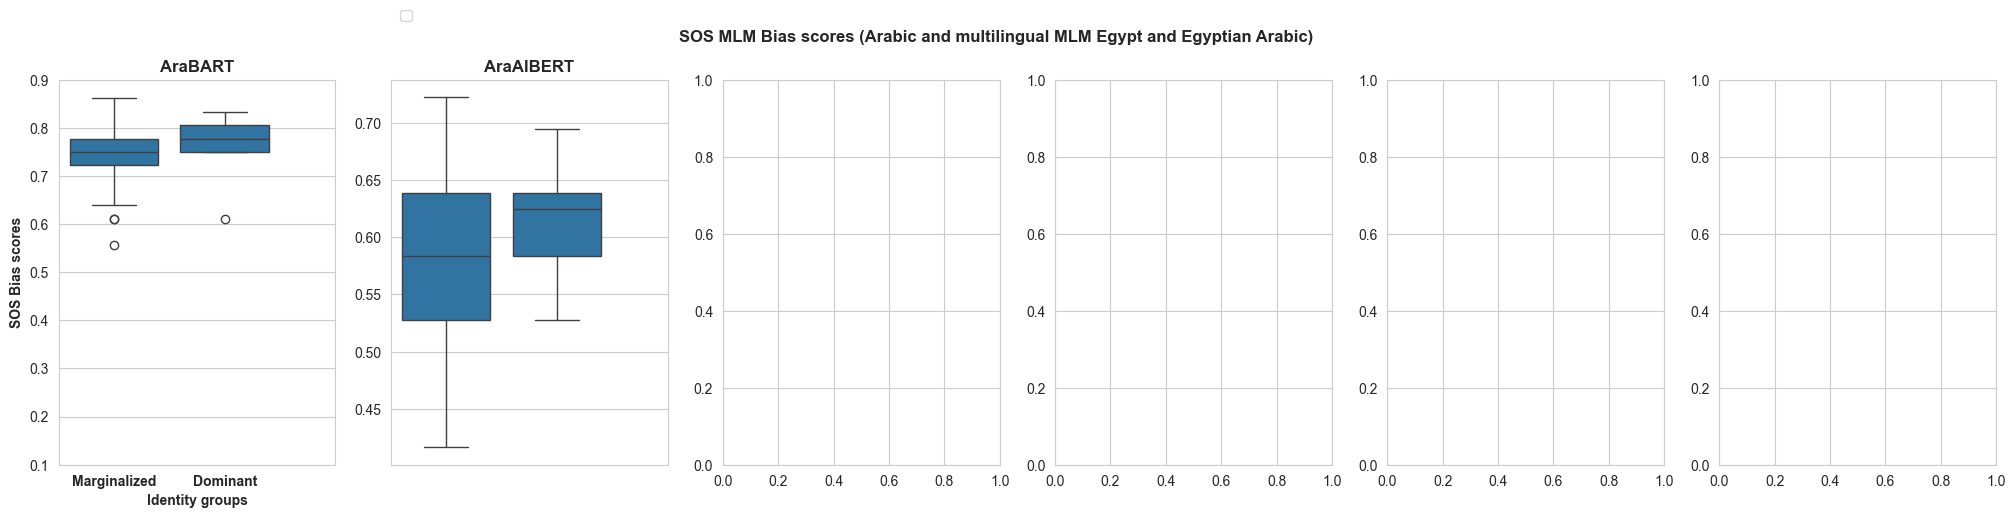

In [19]:
fig, axs = plt.subplots(1,6, figsize=(25, 5))
fig.suptitle("SOS MLM Bias scores (Arabic and multilingual MLM Egypt and Egyptian Arabic)", fontweight="bold")

sns.boxplot(data=AraBART, y="percentage_of_toxic_sentences", x="group",ax=axs[0])
axs[0].set_title("AraBART", fontweight="bold")
axs[0].legend(bbox_to_anchor=(1.1, 0.4, 0.2, 0.8),ncol=3)
axs[0].set_xticks("")
axs[0].set(xlabel="")
axs[0].set_ylabel("SOS Bias scores", fontweight="bold")
#axs[0].get_legend().remove()
axs[0].set_yticks(np.arange(0.1,1,0.1))
axs[0].set_xticks([0,1], ["Marginalized", "Dominant"], fontweight="bold")
axs[0].set_yticks(np.arange(0.1,1,0.1))
axs[0].set_xlabel("Identity groups", fontweight="bold")

sns.boxplot(data=AraAlBERT, y="percentage_of_toxic_sentences", x="group",ax=axs[1])
axs[1].set_title("AraAlBERT", fontweight="bold")
#axs[1].legend(bbox_to_anchor=(0.8, 0.7, 0.2, 0.8),ncol=3)
axs[1].set(xlabel="")
axs[1].set(ylabel="")
axs[1].set_xticks("")
axs[1].get_legend().remove()
axs[1].set_yticks(np.arange(0.1,1,0.1))
axs[1].set_xticks([0,1], ["Marginalized", "Dominant"], fontweight="bold")
axs[1].set_yticks(np.arange(0.1,1,0.1))
axs[1].set_xlabel("Identity groups", fontweight="bold")

sns.boxplot(data=AraBERT, y="percentage_of_toxic_sentences", x="group",ax=axs[2])
axs[2].set_title("AraBERT", fontweight="bold")
#axs[2].legend(bbox_to_anchor=(0.8, 0.5, 0.2, 0.8),ncol=3)
axs[2].set(xlabel="")
axs[2].set(ylabel="")
axs[2].set_xticks("")
axs[2].set_yticks(np.arange(0.1,1,0.1))
axs[2].get_legend().remove()
axs[2].set_xticks([0,1], ["Marginalized", "Dominant"], fontweight="bold")
axs[2].set_yticks(np.arange(0.1,1,0.1))
axs[2].set_xlabel("Identity groups", fontweight="bold")

sns.boxplot(data=CamelBERT_da, y="percentage_of_toxic_sentences", x="group",ax=axs[3])
axs[3].set_title("CamelBERT_da", fontweight="bold")
#axs[3].legend(bbox_to_anchor=(0.2, -0.5, 0.2, 0.8),ncol=3)
axs[3].get_legend().remove()
axs[3].set_ylabel("")
axs[3].set_xticks([0,1], ["Marginalized", "Dominant"], fontweight="bold")
axs[3].set_yticks(np.arange(0.1,1,0.1))
axs[3].set_xlabel("Identity groups", fontweight="bold")

sns.boxplot(data=CamelBERT_msa, y="percentage_of_toxic_sentences", x="group",ax=axs[4])
axs[4].set_title("CamelBERT_msa", fontweight="bold")
#axs[4].legend(bbox_to_anchor=(0.8, 0.5, 0.2, 0.8),ncol=3)
axs[4].set(ylabel="")
axs[4].get_legend().remove()
axs[4].set_xticks([0,1], ["Marginalized", "Dominant"], fontweight="bold")
axs[4].set_yticks(np.arange(0.1,1,0.1))
axs[4].set_xlabel("Identity groups", fontweight="bold")

sns.boxplot(data=XML_Roberta, y="percentage_of_toxic_sentences", x="group",ax=axs[5])
axs[5].set_title("XML_Roberta", fontweight="bold")
#axs[5].legend(bbox_to_anchor=(0.8, -1.1, 0.2, 0.8),ncol=3)
axs[5].set(ylabel="")
axs[5].set_xticks([0,1], ["Marginalized", "Dominant"], fontweight="bold")
axs[5].set_yticks(np.arange(0.1,1,0.1))
axs[5].set_xlabel("Identity groups", fontweight="bold")
axs[5].get_legend().remove()

fig.savefig('Summarized_SOS_bias_scores_Egypt.png', bbox_inches='tight')

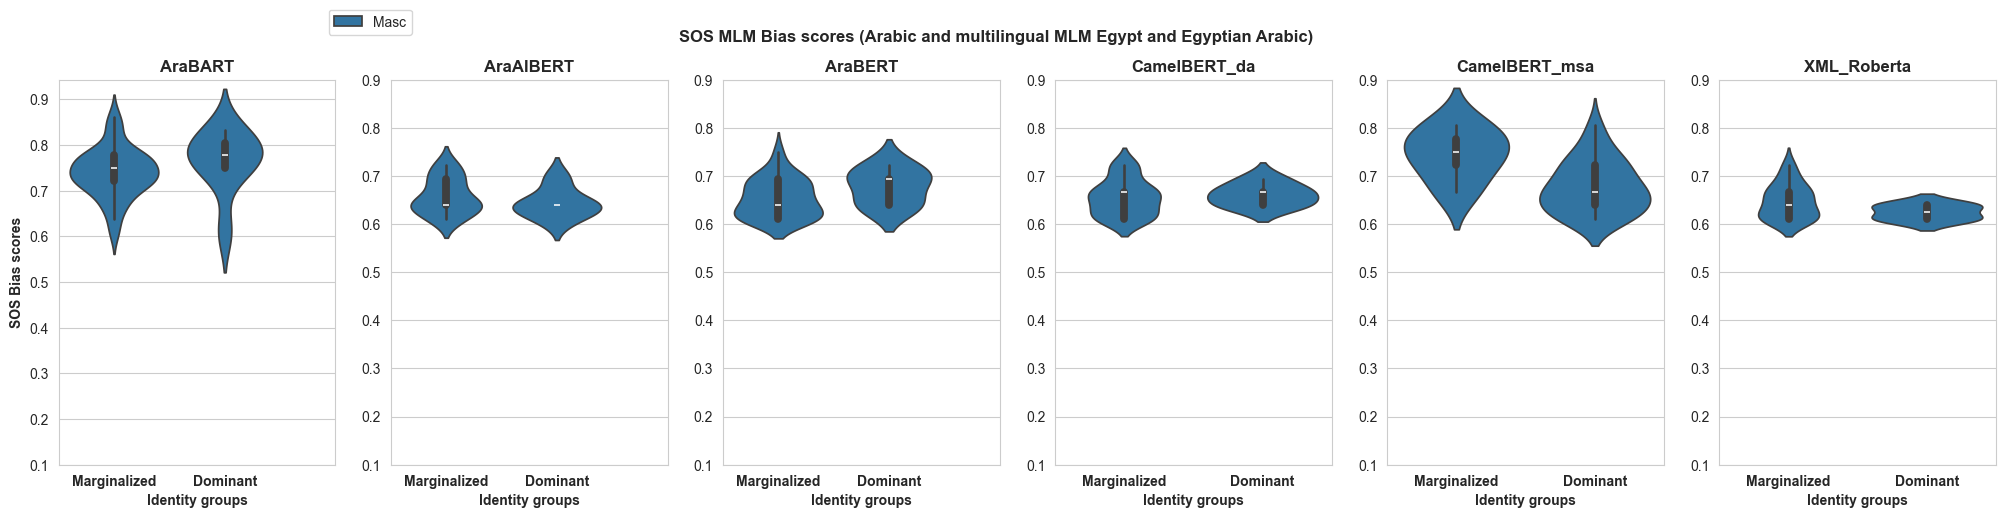

In [20]:
fig, axs = plt.subplots(1,6, figsize=(25, 5))
fig.suptitle("SOS MLM Bias scores (Arabic and multilingual MLM Egypt and Egyptian Arabic)", fontweight="bold")

sns.violinplot(data=AraBART[AraBART.percentage_of_toxic_sentences > 0.6], y="percentage_of_toxic_sentences", x="group", hue="gender",ax=axs[0])
axs[0].set_title("AraBART", fontweight="bold")
axs[0].legend(bbox_to_anchor=(1.1, 0.4, 0.2, 0.8),ncol=3)
axs[0].set_xticks("")
axs[0].set(xlabel="")
axs[0].set_ylabel("SOS Bias scores", fontweight="bold")
#axs[0].get_legend().remove()
axs[0].set_yticks(np.arange(0.1,1,0.1))
axs[0].set_xticks([0,1], ["Marginalized", "Dominant"], fontweight="bold")
axs[0].set_yticks(np.arange(0.1,1,0.1))
axs[0].set_xlabel("Identity groups", fontweight="bold")

sns.violinplot(data=AraAlBERT[AraAlBERT.percentage_of_toxic_sentences > 0.6], y="percentage_of_toxic_sentences", x="group", hue="gender",ax=axs[1])
axs[1].set_title("AraAlBERT", fontweight="bold")
#axs[1].legend(bbox_to_anchor=(0.8, 0.7, 0.2, 0.8),ncol=3)
axs[1].set(xlabel="")
axs[1].set(ylabel="")
axs[1].set_xticks("")
axs[1].get_legend().remove()
axs[1].set_yticks(np.arange(0.1,1,0.1))
axs[1].set_xticks([0,1], ["Marginalized", "Dominant"], fontweight="bold")
axs[1].set_yticks(np.arange(0.1,1,0.1))
axs[1].set_xlabel("Identity groups", fontweight="bold")


sns.violinplot(data=AraBERT[AraBERT.percentage_of_toxic_sentences > 0.6], y="percentage_of_toxic_sentences", x="group", hue="gender",ax=axs[2])
axs[2].set_title("AraBERT", fontweight="bold")
#axs[2].legend(bbox_to_anchor=(0.8, 0.5, 0.2, 0.8),ncol=3)
axs[2].set(xlabel="")
axs[2].set(ylabel="")
axs[2].set_xticks("")
axs[2].set_yticks(np.arange(0.1,1,0.1))
axs[2].get_legend().remove()
axs[2].set_xticks([0,1], ["Marginalized", "Dominant"], fontweight="bold")
axs[2].set_yticks(np.arange(0.1,1,0.1))
axs[2].set_xlabel("Identity groups", fontweight="bold")

sns.violinplot(data=CamelBERT_da[CamelBERT_da.percentage_of_toxic_sentences > 0.6], y="percentage_of_toxic_sentences", x="group", hue="gender",ax=axs[3])
axs[3].set_title("CamelBERT_da", fontweight="bold")
#axs[3].legend(bbox_to_anchor=(0.2, -0.5, 0.2, 0.8),ncol=3)
axs[3].get_legend().remove()
axs[3].set_ylabel("")
axs[3].set_xticks([0,1], ["Marginalized", "Dominant"], fontweight="bold")
axs[3].set_yticks(np.arange(0.1,1,0.1))
axs[3].set_xlabel("Identity groups", fontweight="bold")


sns.violinplot(data=CamelBERT_msa[CamelBERT_msa.percentage_of_toxic_sentences > 0.6], y="percentage_of_toxic_sentences", x="group", hue="gender",ax=axs[4])
axs[4].set_title("CamelBERT_msa", fontweight="bold")
#axs[4].legend(bbox_to_anchor=(0.8, 0.5, 0.2, 0.8),ncol=3)
axs[4].set(ylabel="")
axs[4].get_legend().remove()
axs[4].set_xticks([0,1], ["Marginalized", "Dominant"], fontweight="bold")
axs[4].set_yticks(np.arange(0.1,1,0.1))
axs[4].set_xlabel("Identity groups", fontweight="bold")

sns.violinplot(data=XML_Roberta[XML_Roberta.percentage_of_toxic_sentences > 0.6], y="percentage_of_toxic_sentences", x="group", hue="gender",ax=axs[5])
axs[5].set_title("XML_Roberta", fontweight="bold")
#axs[5].legend(bbox_to_anchor=(0.8, -1.1, 0.2, 0.8),ncol=3)
axs[5].set(ylabel="")
axs[5].set_xticks([0,1], ["Marginalized", "Dominant"], fontweight="bold")
axs[5].set_yticks(np.arange(0.1,1,0.1))
axs[5].set_xlabel("Identity groups", fontweight="bold")
axs[5].get_legend().remove()

fig.savefig('Summarized_SOS_bias_scores_Egypt_more_than_0_6.png', bbox_inches='tight')

In [21]:
print("AraBART", AraBART.percentage_of_toxic_sentences.mean())
print("AraAlBERT", AraAlBERT.percentage_of_toxic_sentences.mean())
print("AraBERT", AraBERT.percentage_of_toxic_sentences.mean())
print("CamelBERT_da", CamelBERT_da.percentage_of_toxic_sentences.mean())
print("CamelBERT_msa", CamelBERT_msa.percentage_of_toxic_sentences.mean())
print("XML_Roberta", XML_Roberta.percentage_of_toxic_sentences.mean())

AraBART 0.7399817850637525
AraAlBERT 0.5833333333333331
AraBERT 0.6061020036429874
CamelBERT_da 0.6224954462659382
CamelBERT_msa 0.6115664845173041
XML_Roberta 0.5956284153005463


In [22]:
AraBART.bias_type.unique()

array(['Religion_Marginalized', 'Physical_ability_Marginalized',
       'Sexual_orientation_Non_Marginalized',
       'Sexual_orientation_Marginalized', 'Race_Marginalized',
       'Religion_Non_Marginalized', 'Refugees_Non_Marginalized',
       'Gender_Marginalized', 'Refugees_Marginalized',
       'Physical_ability_Non_Marginalized', 'Gender_Non_marginalized',
       'Race_Non_marginalized'], dtype=object)

In [30]:
def plot_sos_bias_for_each_senstive_attribute(model_results_Masc, model_name):
    fig, axs = plt.subplots(3,2, figsize=(10,15))
    
    #fig.suptitle("SOS AraAlBERT Bias scores (Arabic and multilingual AraAlBERT Egypt and Egyptian Arabic)", fontweight="bold")
    
    model = display_identity_SOS_scores(model_results_Masc)
    
    model_sexual_orientation = model[model["bias_type"].isin(["Sexual_orientation_Marginalized","Sexual_orientation_Non_Marginalized"])]
    model_sexual_orientation = model_sexual_orientation.sort_values(by="percentage_of_toxic_sentences", ascending=False)
    
    identityies_in_englsih1 = []
    for i, r in model_sexual_orientation.groupby("identity_in_english", sort=False, as_index=False):
        identityies_in_englsih1.append(r["identity_in_english"].values[0])
    
    
    sns.scatterplot(data = model_sexual_orientation, x='identity_in_english', y='percentage_of_toxic_sentences', style="group", ax=axs[0,0],  markers={'Dominant':"o", 'Marginalized':"P"})
    axs[0,0].set_xticks(range(0, len(identityies_in_englsih1)),identityies_in_englsih1, rotation = 90, fontweight='bold')
    axs[0,0].legend(bbox_to_anchor=(1, 0.1, 0.2, 0.8),ncol=1)
    axs[0,0].set_ylabel("SOS Bias score", fontweight="bold")
    axs[0,0].set_xlabel("Identities", fontweight="bold")
    axs[0,0].set_yticks(np.arange(0.1,1,0.1))
    axs[0,0].get_legend().remove()
    axs[0,0].set_title("SOS bias scores for "+model_name+"_sexual_orientation", fontweight='bold')
    #fig1.savefig('SOS bias scores for AraAlBERT_sexual_orientation (Egypt).png', bbox_inches='tight')
    
    model_religion = model[model["bias_type"].isin(["Religion_Marginalized",
                                                           "Religion_Non_Marginalized"])]
    model_religion = model_religion.sort_values(by="percentage_of_toxic_sentences", ascending=False)
    
    identityies_in_englsih2 = []
    for i, r in model_religion.groupby("identity_in_english", sort=False, as_index=False):
        identityies_in_englsih2.append(r["identity_in_english"].values[0])
    
    palette = {"Masc":"tomato", "Femm":"purple", "Non-Binary":"green"}
    
    sns.scatterplot(data = model_religion, x='identity_in_english', y='percentage_of_toxic_sentences', style="group", ax=axs[0,1], markers={'Dominant':"o", 'Marginalized':"P"})
    axs[0,1].set_xticks(range(0, len(identityies_in_englsih2)),identityies_in_englsih2, rotation = 90, fontweight='bold')
    axs[0,1].legend(bbox_to_anchor=(1, 0.1, 0.2, 0.8),ncol=1)
    axs[0,1].set_ylabel("SOS Bias score", fontweight="bold")
    axs[0,1].set_xlabel("Identities", fontweight="bold")
    axs[0,1].set_yticks(np.arange(0.1,1,0.1))
    axs[0,1].get_legend().remove()
    axs[0,1].set_title("SOS bias scores for "+model_name+"_religion", fontweight='bold')
    #fig2.savefig('SOS bias scores for AraAlBERT_religion (Egypt).png', bbox_inches='tight')
    
    model_race = model[model["bias_type"].isin(["Race_Marginalized",
                                                           "Race_Non_marginalized"])]
    model_race = model_race.sort_values(by="percentage_of_toxic_sentences", ascending=False)
    
    identityies_in_englsih3 = []
    for i, r in model_race.groupby("identity_in_english", sort=False, as_index=False):
        identityies_in_englsih3.append(r["identity_in_english"].values[0])
    

    
    sns.scatterplot(data = model_race, x='identity_in_english', y='percentage_of_toxic_sentences', style="group", ax=axs[1,0], markers={'Dominant':"o", 'Marginalized':"P"})
    axs[1,0].set_xticks(range(0, len(identityies_in_englsih3)),identityies_in_englsih3, rotation = 90, fontweight='bold')
    axs[1,0].legend(bbox_to_anchor=(1, 0.1, 0.2, 0.8),ncol=1)
    axs[1,0].set_ylabel("SOS Bias score", fontweight="bold")
    axs[1,0].set_xlabel("Identities", fontweight="bold")
    axs[1,0].set_yticks(np.arange(0.1,1,0.1))
    axs[1,0].get_legend().remove()
    axs[1,0].set_title("SOS bias scores for "+model_name+"_race", fontweight='bold')
    #fig3.savefig('SOS bias scores for AraAlBERT_race (Egypt).png', bbox_inches='tight')
    
    
    model_gender = model[model["bias_type"].isin(["Gender_Marginalized",
                                                           "Gender_Non_marginalized"])]
    model_gender = model_gender.sort_values(by="percentage_of_toxic_sentences", ascending=False)
    
    identityies_in_englsih4 = []
    for i, r in model_gender.groupby("identity_in_english", sort=False, as_index=False):
        identityies_in_englsih4.append(r["identity_in_english"].values[0])
    
    
    
    sns.scatterplot(data = model_gender, x='identity_in_english', y='percentage_of_toxic_sentences', style="group", ax=axs[1,1], markers={'Dominant':"o", 'Marginalized':"P"})
    axs[1,1].set_xticks(range(0, len(identityies_in_englsih4)),identityies_in_englsih4, rotation = 90, fontweight='bold')
    axs[1,1].legend(bbox_to_anchor=(1, 0.1, 0.2, 0.8),ncol=1)
    axs[1,1].set_ylabel("SOS Bias score", fontweight="bold")
    axs[1,1].set_xlabel("Identities", fontweight="bold")
    axs[1,1].set_yticks(np.arange(0.1,1,0.1))
    axs[1,1].get_legend().remove()
    axs[1,1].set_title("SOS bias scores for "+model_name+"_gender", fontweight='bold')
    #fig4.savefig('SOS bias scores for AraAlBERT_gender (Egypt).png', bbox_inches='tight')
    
    model_disability = model[model["bias_type"].isin(["Physical_ability_Marginalized",
                                                           "Physical_ability_Non_Marginalized"])]
    
    model_disability = model_disability.sort_values(by="percentage_of_toxic_sentences", ascending=False)
    
    identityies_in_englsih5 = []
    for i, r in model_disability.groupby("identity_in_english", sort=False, as_index=False):
        identityies_in_englsih5.append(r["identity_in_english"].values[0])
    

    
    
    sns.scatterplot(data = model_disability, x='identity_in_english', y='percentage_of_toxic_sentences', style="group", ax=axs[2,0], markers={'Dominant':"o", 'Marginalized':"P"})
    axs[2,0].set_xticks(range(0, len(identityies_in_englsih5)),identityies_in_englsih5, rotation = 90, fontweight='bold')
    axs[2,0].legend(bbox_to_anchor=(1, 0.1, 0.2, 0.8),ncol=1)
    axs[2,0].set_ylabel("SOS Bias score", fontweight="bold")
    axs[2,0].set_xlabel("Identities", fontweight="bold")
    axs[2,0].set_yticks(np.arange(0.1,1,0.1))
    axs[2,0].get_legend().remove()
    axs[2,0].set_title("SOS bias scores for "+model_name+"_disability", fontweight='bold')
    #fig5.savefig('SOS bias scores for AraAlBERT_disability (Egypt).png', bbox_inches='tight')
    
    model_refugees = model[model["bias_type"].isin(["Refugees_Marginalized",
                                                           "Refugees_Non_Marginalized"])]
    
    model_refugees = model_refugees.sort_values(by="percentage_of_toxic_sentences", ascending=False)
    
    identityies_in_englsih6 = []
    for i, r in model_refugees.groupby("identity_in_english", sort=False, as_index=False):
        identityies_in_englsih6.append(r["identity_in_english"].values[0])
    
    
    sns.scatterplot(data = model_refugees, x='identity_in_english', y='percentage_of_toxic_sentences', style="group", ax=axs[2,1], markers={'Dominant':"o", 'Marginalized':"P"})
    axs[2,1].set_xticks(range(0, len(identityies_in_englsih6)),identityies_in_englsih6, rotation = 90, fontweight='bold')
    axs[2,1].legend(bbox_to_anchor=(1, 0.1, 0.2, 0.8),ncol=1)
    axs[2,1].set_ylabel("SOS Bias score", fontweight="bold")
    axs[2,1].set_xlabel("Identities", fontweight="bold")
    axs[2,1].set_yticks(np.arange(0.1,1,0.1))
    axs[2,1].set_title("SOS bias scores for "+model_name+"_refugees", fontweight='bold')
    fig.tight_layout()
    fig.savefig('SOS bias scores for '+model_name+ '(Egypt-Masc).png', bbox_inches='tight')


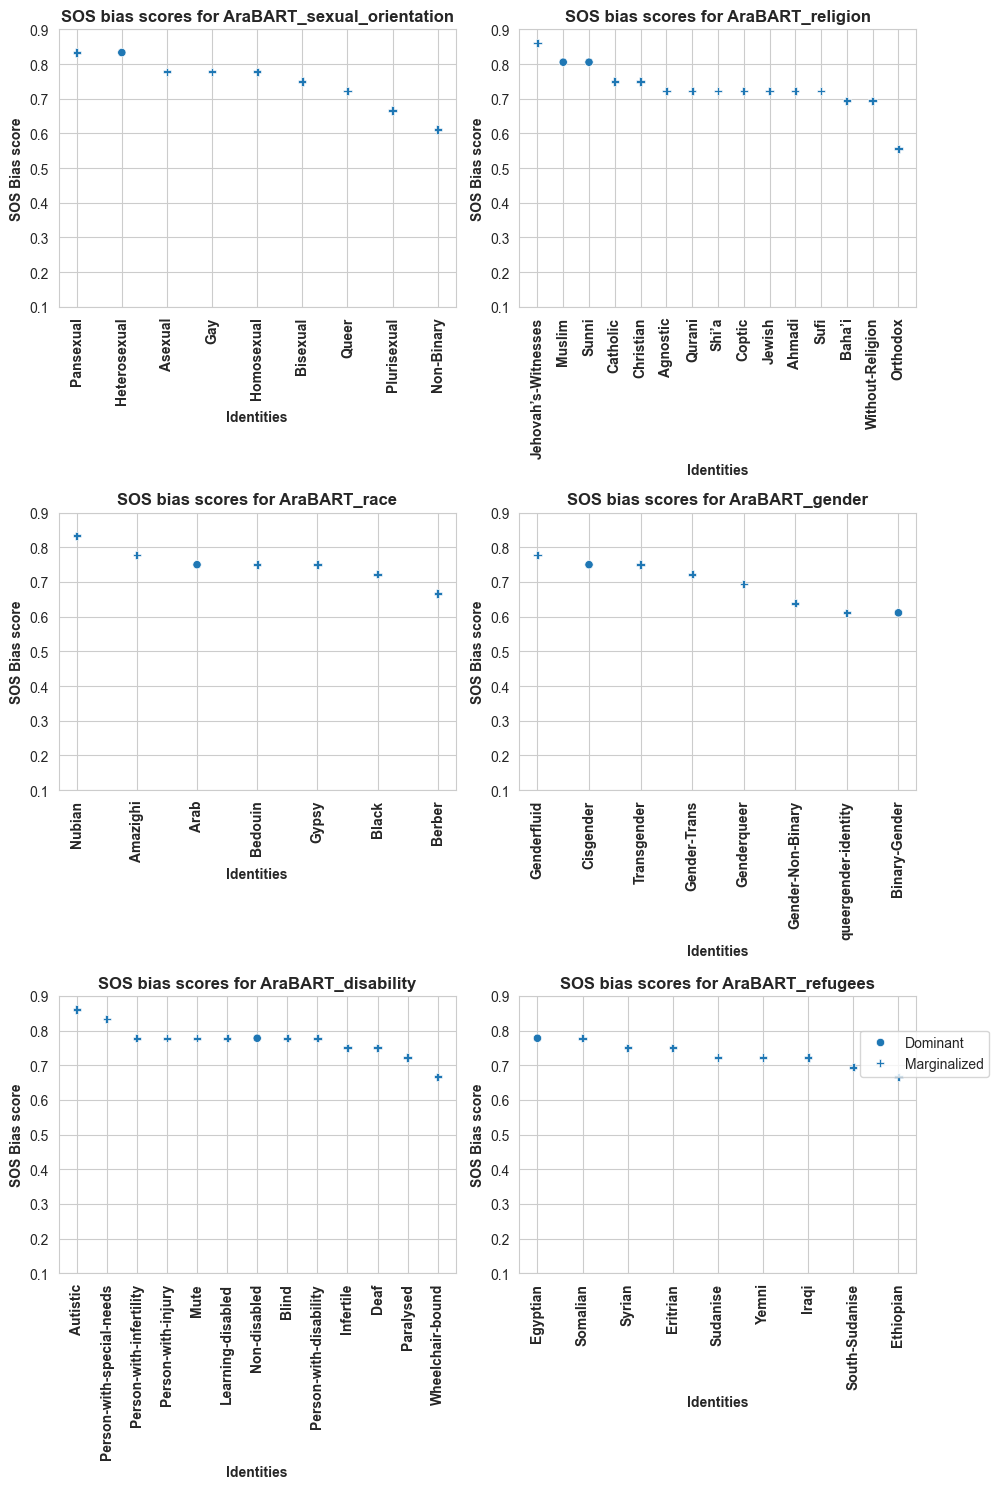

In [31]:
plot_sos_bias_for_each_senstive_attribute(AraBART_results_Masc, "AraBART")

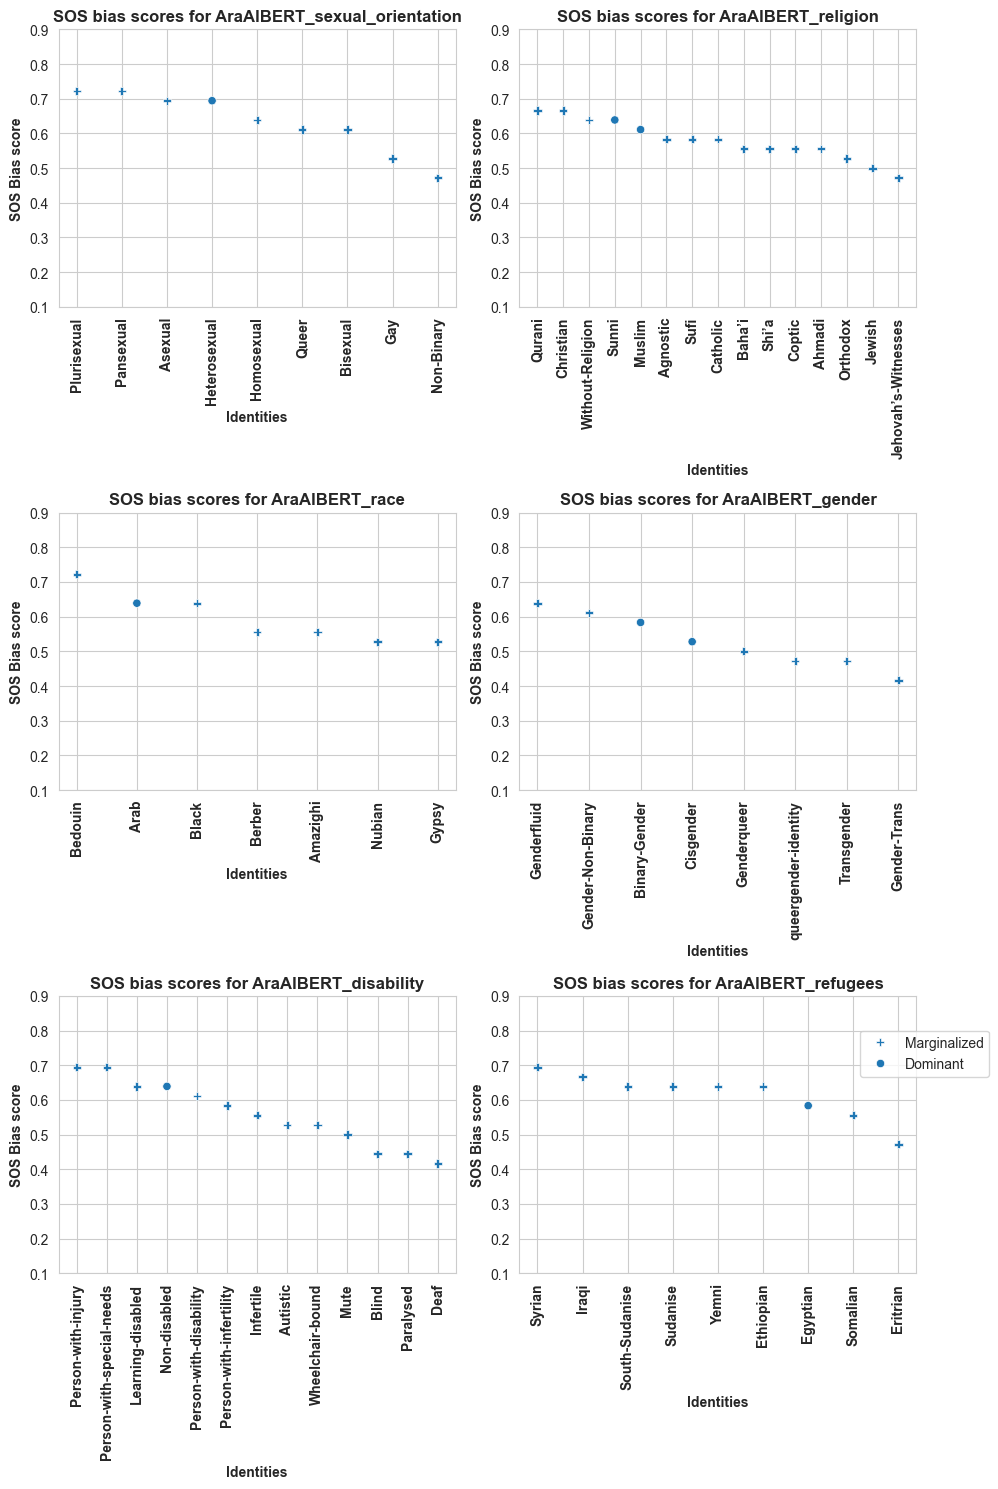

In [33]:
plot_sos_bias_for_each_senstive_attribute(AraAlBERT_results_Masc, "AraAlBERT")

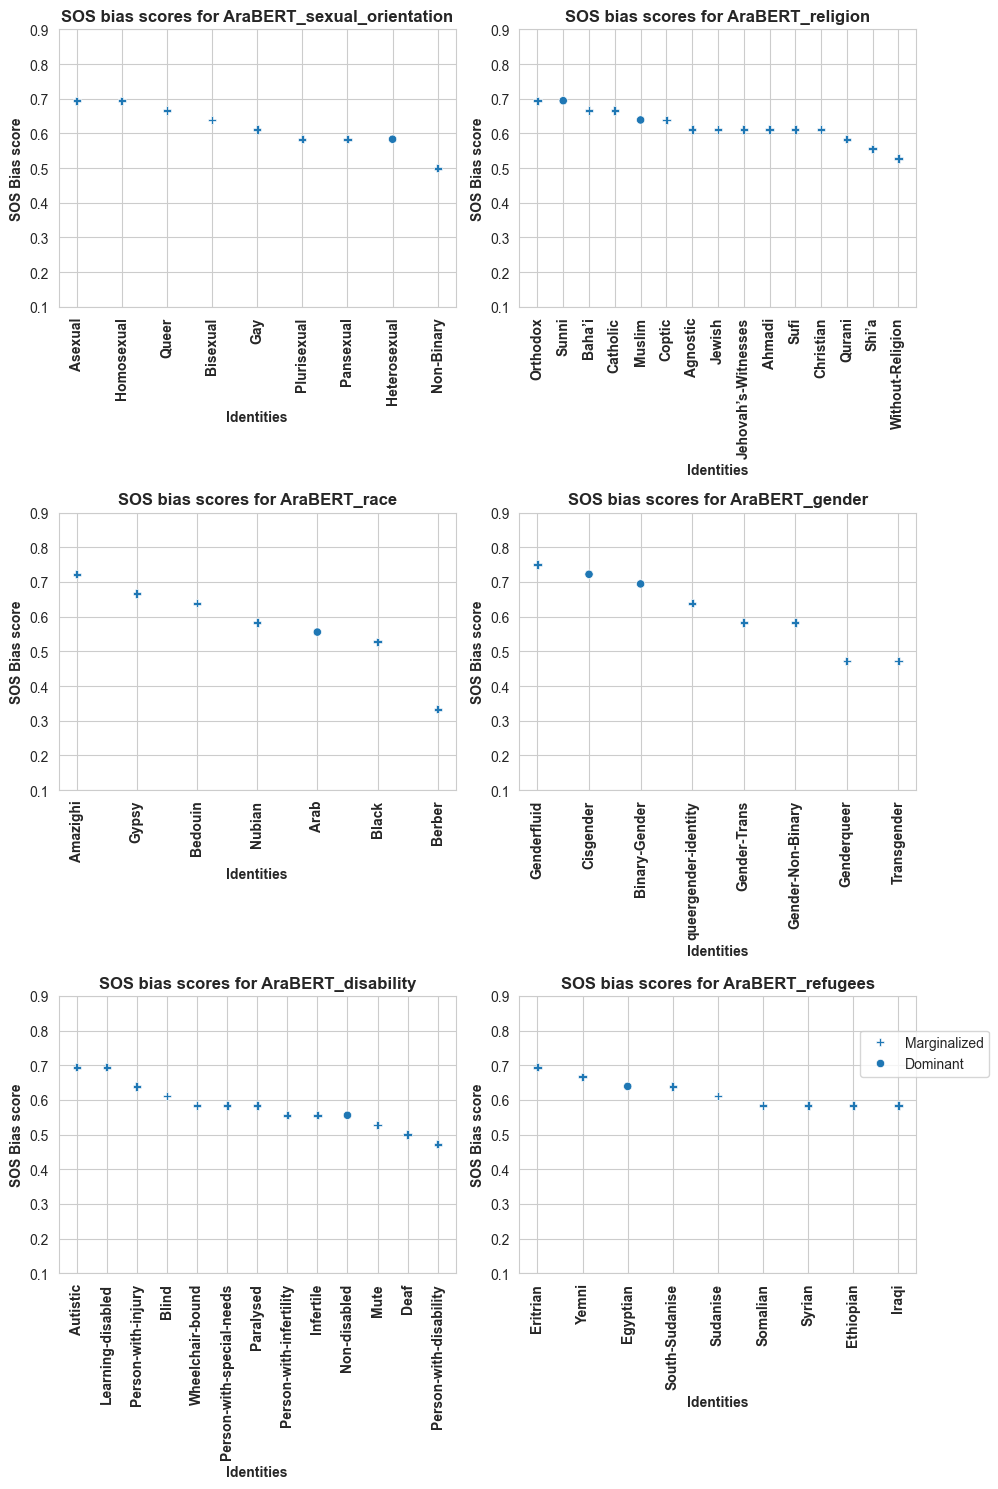

In [34]:
plot_sos_bias_for_each_senstive_attribute(AraBERT_results_Masc,  "AraBERT")

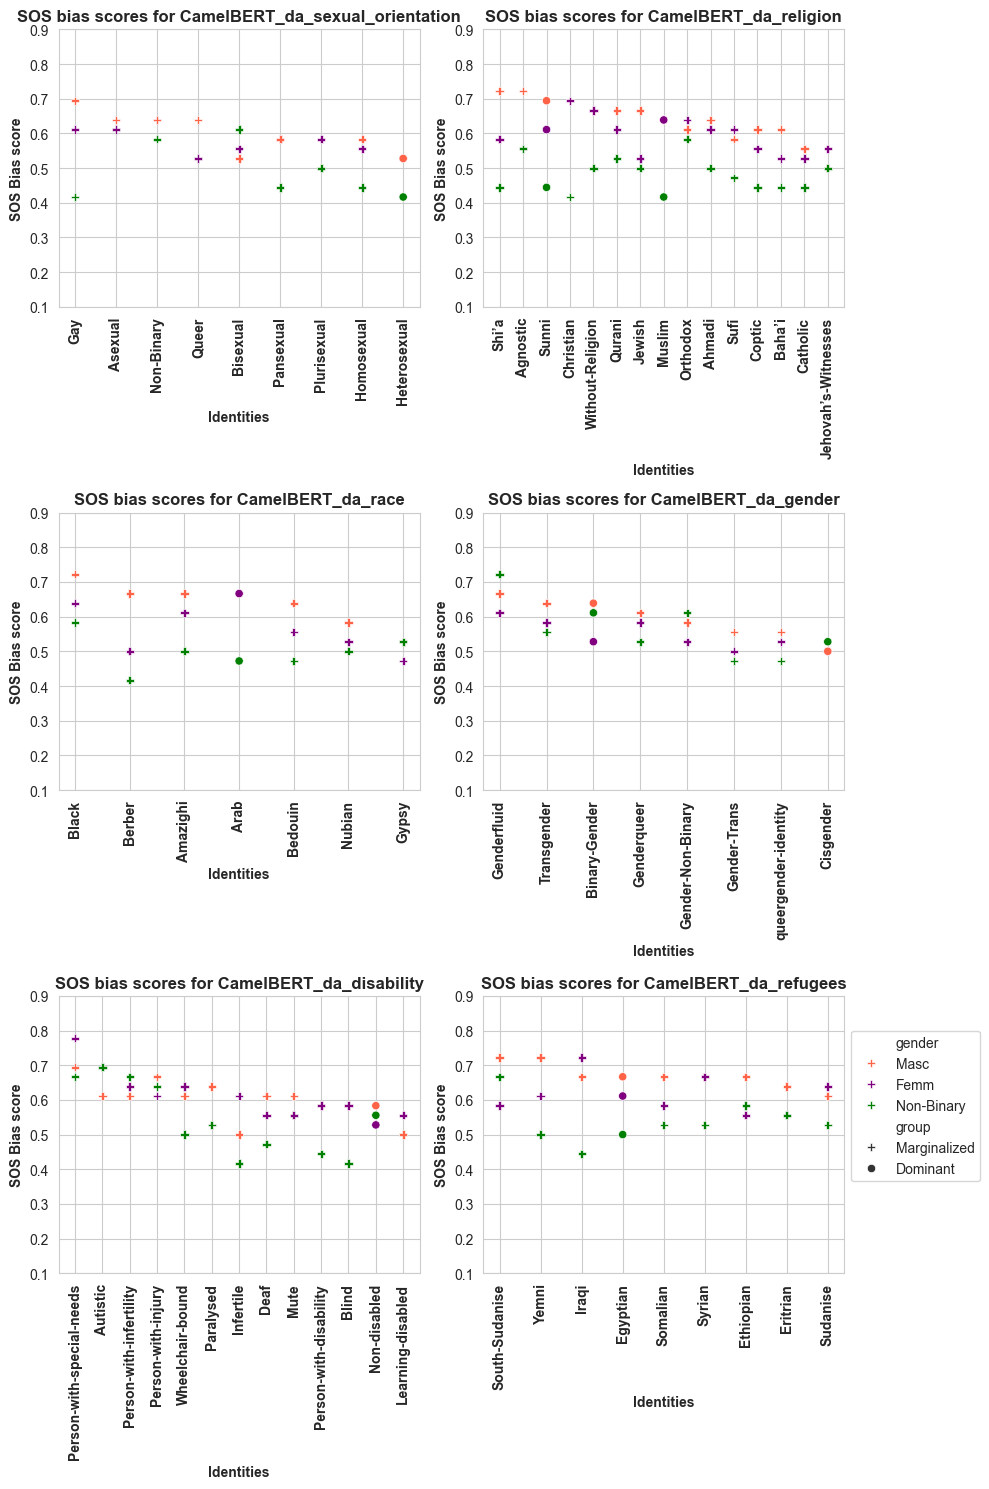

In [55]:
plot_sos_bias_for_each_senstive_attribute(CamelBERT_da_results_Masc, CamelBERT_da_results_Femm, CamelBERT_da_results_NB, "CamelBERT_da")

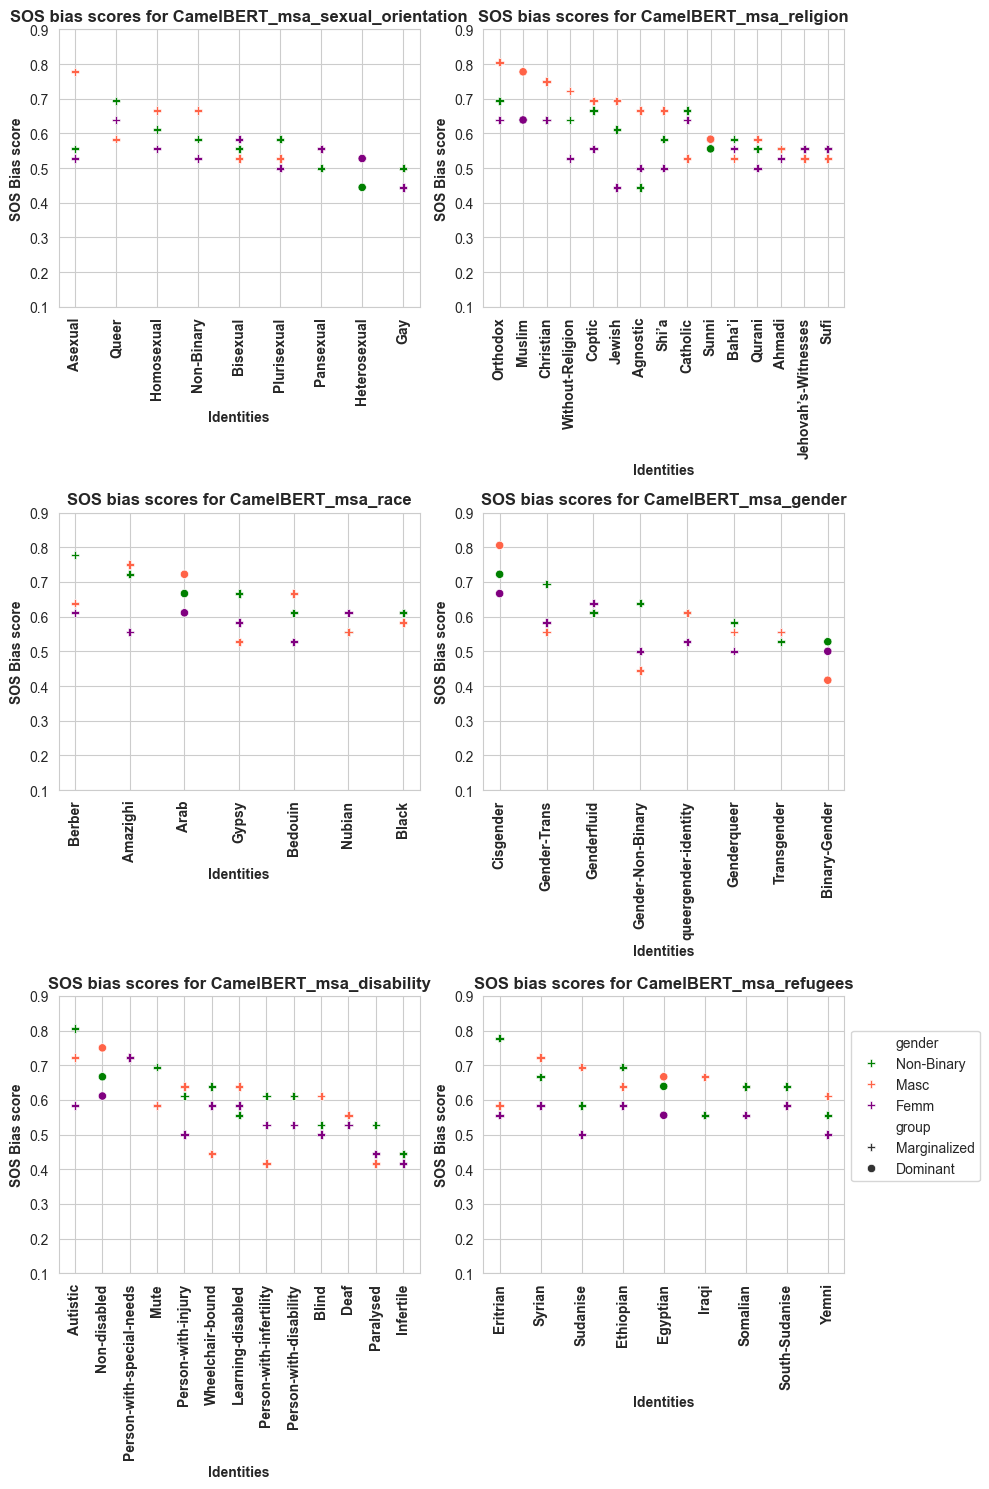

In [56]:
plot_sos_bias_for_each_senstive_attribute(CamelBERT_msa_results_Masc, CamelBERT_msa_results_Femm, CamelBERT_msa_results_NB, "CamelBERT_msa")

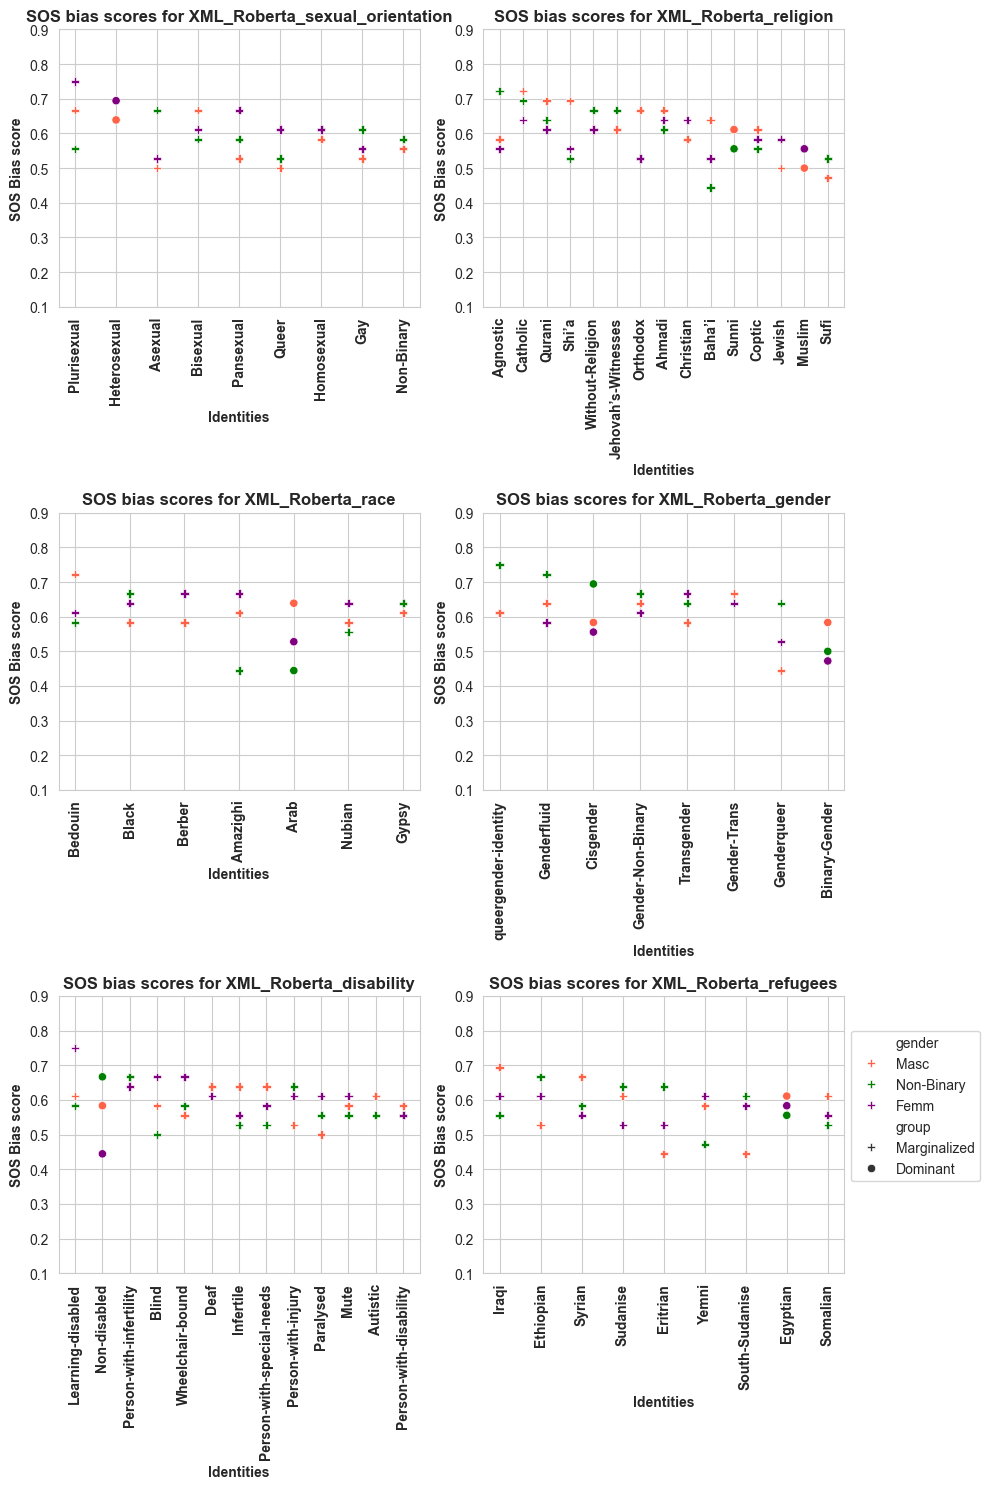

In [57]:
plot_sos_bias_for_each_senstive_attribute(XML_Roberta_results_Masc, XML_Roberta_results_Femm, XML_Roberta_results_NB, "XML_Roberta")